In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
user_df = pd.read_csv('data\\ratings.csv')
user_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies_df = pd.read_csv('data\\movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print('Number of users: ', len(pd.unique(user_df['userId'])))
print('Number of movies: ', len(pd.unique(movies_df['movieId'])))

Number of users:  610
Number of movies:  9742


# Exploring the genres

## First, we'll look at the number of times each of the listed genres has been assigned to a movie in the data set

From the plot, we can see that Drama is the most populous genre in the data set with 4361 occurences. This is followed by Comedy, Thriller, Action, and Romance

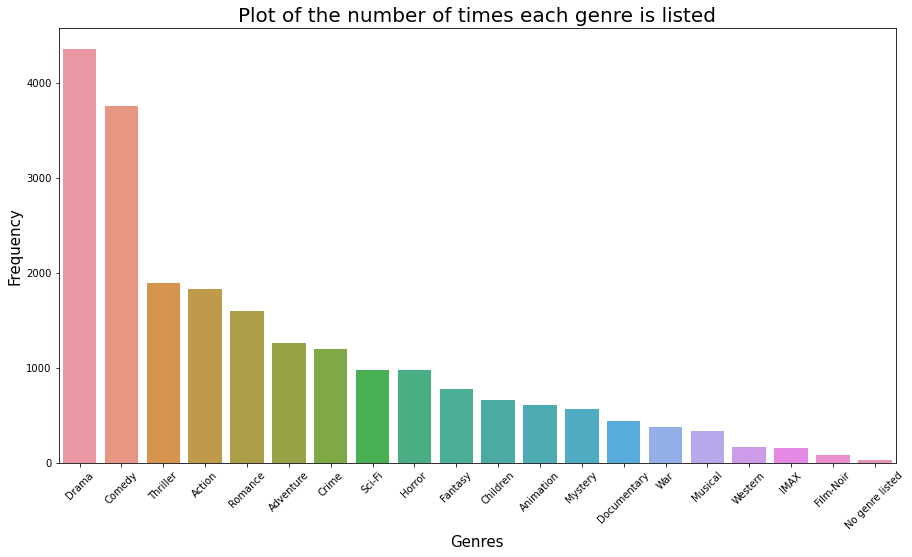

In [5]:
#Find out the frequency of genres
genres = movies_df['genres'].str.split("[|, ' ']",expand=True).stack().value_counts()
genres['No genre listed'] = genres['(no']
del genres['genres']
del genres['listed)']
del genres['(no']
keys = list(genres.keys())
values = [genres[k] for k in keys]
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Plot of the number of times each genre is listed',fontsize=20)
sns.barplot(x=keys, y=values)

In [6]:
#TODO
#find 5 movies with highest consolidated ratings, and their genres
#find 5 movies with lowest consolidated ratings, and their genres
#find the genres with the highest normalized rating (add the ratings together for each movie that has a specific 
# genre, divide it by the number of times that genre comes up)
#find the preferences of a single user

## Let's look at the highest and the worst rated movies and the genres they are listed under

In [7]:
#Sort the movie ids by arithmetic means of their rating, non-ascending
sorted_rating = user_df[['movieId','rating']].groupby('movieId').mean().sort_values(by='rating', ascending=False)
#Join the movies db with movieId to find the names of the movies
sorted_rating_names = pd.merge(sorted_rating, movies_df, on = 'movieId')
sorted_rating_names.head()


,movieId,rating,title,genres
0,88448,5.0,Paper Birds (Pájaros de papel) (2010),Comedy|Drama
1,100556,5.0,"Act of Killing, The (2012)",Documentary
2,143031,5.0,Jump In! (2007),Comedy|Drama|Romance
3,143511,5.0,Human (2015),Documentary
4,143559,5.0,L.A. Slasher (2015),Comedy|Crime|Fantasy


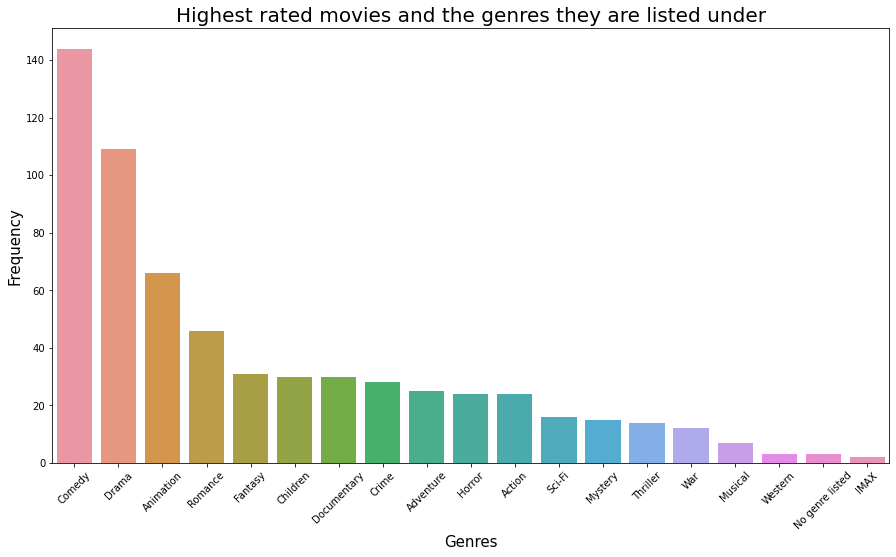

In [8]:
#Get the genres of the movies rated five stars and plot their distribution
genres_top = sorted_rating_names[sorted_rating_names['rating'] == 5.0]['genres'].str.split("[|, ' ']", expand=True).stack().value_counts()
genres_top['No genre listed'] = genres_top['(no']
del genres_top['genres']
del genres_top['listed)']
del genres_top['(no']
genres_top = dict(sorted(genres_top.items(), key=lambda item: item[1], reverse=True))
keys = list(genres_top.keys())
values = [genres_top[k] for k in keys]
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Highest rated movies and the genres they are listed under',fontsize=20)
sns.barplot(x=keys, y=values)

People seem to enjoy comedy movies the most, as this category has the most number of films rated 5 stars. 

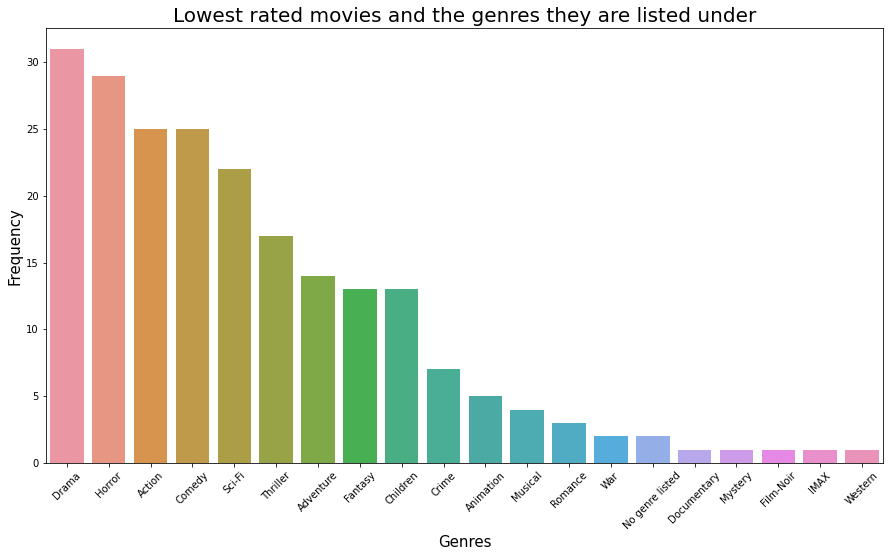

In [9]:
#Get the genres of the movies rated 0.5 stars and plot their distribution
genres_low = sorted_rating_names[sorted_rating_names['rating'] == 0.5]['genres'].str.split("[|, ' ']", expand=True).stack().value_counts()
genres_low['No genre listed'] = genres_low['(no']
del genres_low['genres']
del genres_low['listed)']
del genres_low['(no']
genres_low = dict(sorted(genres_low.items(), key=lambda item: item[1], reverse=True))
keys = list(genres_low.keys())
values = [genres_low[k] for k in keys]
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Lowest rated movies and the genres they are listed under',fontsize=20)
sns.barplot(x=keys, y=values)

Drama and horror seem to lead in this category as the genres of the worst rated movies. An interesting fact here is that drama is in both the best rated and worst rated movies. This may indicate that the dataset in unbalanced and that a high number of movies tend to be classified under the genre 'Drama'

# Let's try to find the genres that have received the highest consolidated rating

In [10]:
def return_genre_consolidated_rating(df):
    #first let's replace (No genres listed) with an easily splittable value
    df['genres'] = df['genres'].str.replace('(no genres listed)', 'no_genre_listed', regex = False)
    #now split the genres column
    stacked_df = pd.DataFrame(df['genres'].str.split("[|, ' ']",expand=True).stack())
    stacked_df.reset_index(inplace=True)
    stacked_df.columns = ['movieId', 'genreNumber', 'genre']
    df = pd.merge(df, stacked_df, on = 'movieId')
    df = df[['genre', 'rating']].groupby('genre').mean()
    df = df.reset_index()
    return df

Text(0, 0.5, 'Average Rating')

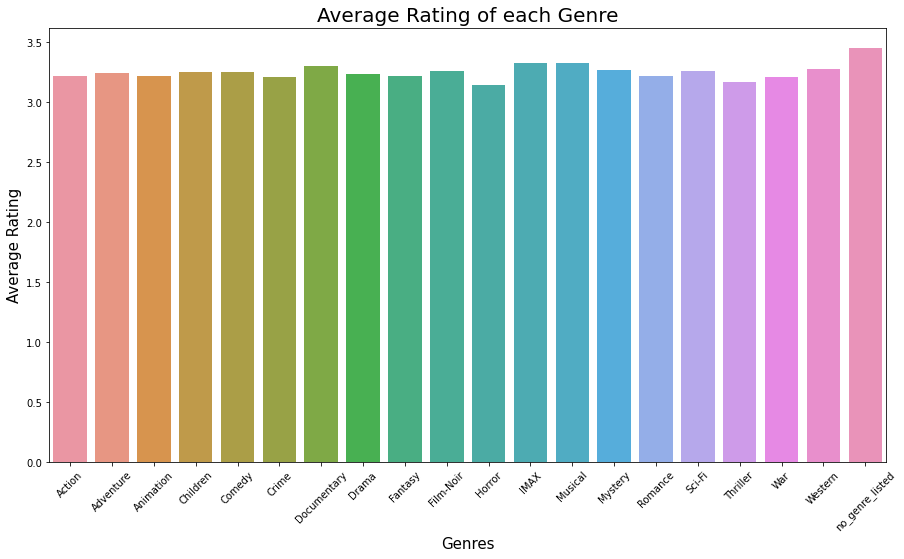

In [11]:
consolidated_genre_rating = return_genre_consolidated_rating(sorted_rating_names)
#consolidated_genre_rating.reset_index()
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.title('Average Rating of each Genre',fontsize=20)
sns.barplot(x = consolidated_genre_rating['genre'], y = consolidated_genre_rating['rating'])
plt.xlabel('Genres', fontsize=15)
plt.ylabel('Average Rating', fontsize=15)

It seems we do not get any useful insights from this analysis. The average rating for each genre tends towards the 'average' possible rating i.e. 3 

# Analysing the preferences of a single user

Let's try to look at the number of ratings a user has submitted, his/her favorite movies and the genres they come under, his/her least favorite movies and the genres they fall under